In [1]:

import yaml
import torch

thresh = 0.7

for i in range(6):
    with open(f'stats/country_{i}.f1s', 'r') as f:
        f1s = yaml.load(f.read())
    temp = torch.tensor(f1s).mean()
    if temp > thresh:
        print(i)

for i in range(11):
    with open(f'stats/rural_{i}.f1s', 'r') as f:
        f1s = yaml.load(f.read())
    temp = torch.tensor(f1s).mean()
    if temp > thresh:
        print(i)

/data2/kuntai/envs/dds/lib/python3.7/site-packages/ipykernel_launcher.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  
/data2/kuntai/envs/dds/lib/python3.7/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


0
1
2
3
4
5
0
8
9


In [4]:
import matplotlib.pyplot as plt

# from config import settings

import pymongo
%matplotlib inline

plt.style.use('ggplot')


# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
db = pymongo.MongoClient("mongodb://localhost:27017/")['Sep4_reducto']


from joblib import Parallel, delayed, Memory


mem = Memory('/tank/kuntai/joblib_cache',verbose=0)


plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 35
plt.rcParams['pdf.fonttype'] = 42
# colors = [
#     "#1F4690", # oneadapt
#     "#576F72", # baseline 1
#     "#850E35", # baseline 2
#     "#614124", # baseline 3
# ]
colors = [
    '#004daf',
    '#ed1b3a',
    '#ff9900',
    '#33a02c',
    '#fabeaf',
    '#aad59b'
]
bandwidth = 20 * 1000 * 1000 / 8 # 20 Mbps
inference = 0.05
latency = 0.03 # 30ms network latency

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fig.savefig(f'{filename}_time_{timestr}.pdf', bbox_inches='tight')
    fig.savefig(f'{filename}.pdf', bbox_inches='tight')

In [5]:
@mem.cache
def single_query(query):
    x = list(db['examine'].find(query))
    x = sorted(x, key = lambda x: x['_id'])
    return x[-1]
    

@mem.cache
def query_approach(fmt, approach="", column='stats'):
    
    try:
        stats = []

        stats = Parallel(n_jobs=4,prefer='threads')(delayed(single_query)({
                'my_args.second': sec,
                'my_args.command_line_args.approach': approach,
                'my_args.input': fmt,
            }) for sec in range(0, 119))

        return np.mean([i['my_video_config']['bw']/bandwidth+len(i['my_video_config']['encoded_frames'])*inference for i in stats]), np.mean([i['f1'] for i in stats])
    except IndexError as e:
        print(fmt)
        print(approach)
        raise e


@mem.cache
def query_approach2(fmt, approach="", column='stats'):
    
    try:
        stats = []

        stats = Parallel(n_jobs=4,prefer='threads')(delayed(single_query)({
                'my_args.second': sec,
                'my_args.command_line_args.approach': approach,
                'my_args.input': fmt,
            }) for sec in range(0, 119))

        return stats
    except IndexError as e:
        print(fmt)
        print(approach)
        raise e
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)

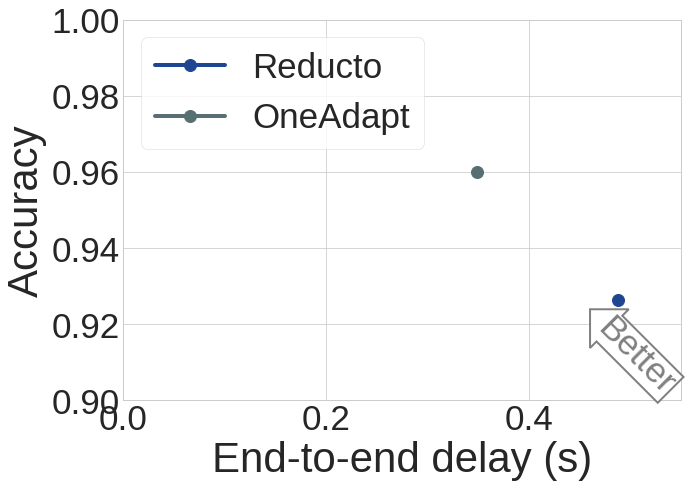

[[0.11135028 0.99215686]
 [0.12845028 0.95420168]
 [0.37396653 0.84817275]
 [0.34869484 0.96005946]
 [0.18366213 0.93068972]
 [0.15378643 0.93937196]
 [0.21832328 0.92614668]
 [0.23875697 0.8720407 ]]
[[0.11135028 0.99215686]
 [0.12845028 0.95420168]
 [0.37396653 0.84817275]
 [0.30619064 0.93228635]
 [0.18366213 0.93068972]
 [0.15378643 0.93937196]
 [0.21379046 0.91821017]
 [0.23332714 0.86483782]]
[[0.10610962 0.98419578]
 [0.12845028 0.95420168]
 [0.36056269 0.83290664]
 [0.29887726 0.9286449 ]
 [0.17208281 0.91877223]
 [0.15378643 0.93937196]
 [0.18814365 0.88738451]
 [0.21152251 0.84312645]]
[[0.25730896 0.99062898]
 [0.31518664 0.95618443]
 [0.69035269 0.89928998]
 [0.57900102 0.95879829]
 [0.40439353 0.92872878]
 [0.35587187 0.96538798]
 [0.39362186 0.93506835]
 [0.48258609 0.91288464]]
[[0.25730896 0.99062898]
 [0.24928112 0.94102337]
 [0.51364697 0.8604006 ]
 [0.48755492 0.92630647]
 [0.35630097 0.92788845]
 [0.30111212 0.9432493 ]
 [0.29578114 0.92043661]
 [0.42501159 0.895212

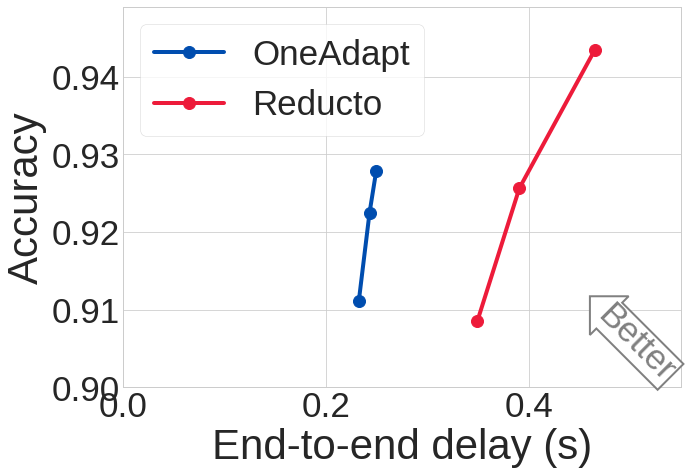

In [113]:


import numpy as np
# fmt = '/dataheart/dataset/rural/rural_1/part%d.mp4'

# v_list = [('country', '%d' % i) for i in [0,1,2,3,4,5]] + [('rural', '%d' % i) for i in [0, 8, 9]]
v_list = [('country', '%d' % i) for i in [0,2,3,4,5]] + [('rural', '%d' % i) for i in [0, 8, 9]]

# v_list = [v_list[0]]

fig, ax = plt.subplots(figsize=(10, 7))


x = []

for compute_weight in [0.8, 1.0, 1.2]:

    y = []
    for v, idx in v_list:
        approach = f'oneadapt_reducto_weight_{compute_weight}'
        fmt = f'/dataheart/dataset/{v}/{v}_{idx}/part%d.mp4'
        y.append(query_approach(fmt, approach))
    y = np.array(y)
    print(y)
    x.append(np.mean(y, axis=0))
    
ax.plot([i[0]+latency for i in x], [i[1] for i in x], label='OneAdapt', c=colors[0], marker='o', linewidth=4, markersize=12)


x = []

for compute_weight in [0.01, 0.04, 0.07]:
    for freq in [4]:

        y = []

        for v, idx in v_list:
            approach = f'reducto_weight_{compute_weight}_freq_{freq}'
            fmt = f'/dataheart/dataset/{v}/{v}_{idx}/part%d.mp4'
            y.append(query_approach(fmt, approach))
        y = np.array(y)

        print(y)

        x.append(np.mean(y, axis=0))
ax.plot([i[0]+latency for i in x], [i[1] for i in x], label='Reducto', c=colors[1], marker='o', linewidth=4, markersize=12)    






# x = []
# for compute_weight in [0.5, 1, 1.5, 2]:

#     approach = f'backprop_reducto_cheap_comp_weight_{compute_weight}'
#     x.append(query_approach(fmt, approach))
#     print(x[-1])
    
    
# ax.scatter([i[0] for i in x], [i[1] for i in x], label='BP-Adapt')


# x = []
# for compute_weight in [2, 0.1]:
#     for freq in [10]:
#         approach = approach = f'reducto_newstart_expensive_comp_weight_{compute_weight}_freq_{freq}'
#         x.append(query_approach(fmt, approach))
    
# ax.scatter([i[0] for i in x], [i[1] for i in x], label='Reducto')
# stats = x[-1]
# ax.scatter(range(len(stats)), [len(i['encoded_frames']) for i in stats])


# x = [] 
# for qp in [24, 26, 28, 30, 32, 34, 36]:
#     x.append(query_approach(fmt, {'qp': qp}))
    
# print(x)
    

l, r = 0, 0.55
b, u = 0.9, 0.949

ax.set_xlim(l,r)
ax.set_ylim(b,u)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('End-to-end delay (s)')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props, c='grey')

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

ax.legend(loc=2,frameon=True)

In [114]:
savefig('/home/kuntai/paper/DiffAdapt-HotNets/figs/tradeoff-RGB-filtering', fig)

1.7647058823529411
3.5210084033613445


/data2/kuntai/envs/dds/lib/python3.7/site-packages/ipykernel_launcher.py:29: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


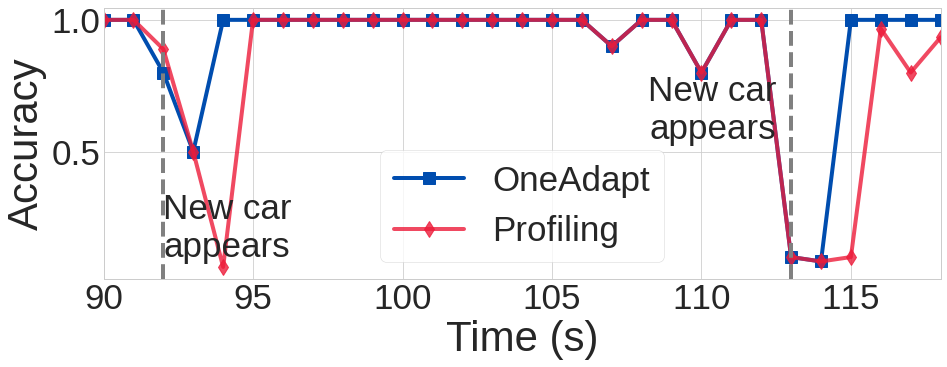

In [14]:


import numpy as np
idx = 2
fmt = f'/dataheart/dataset/country/country_{idx}/part%d.mp4'

    

fig, ax = plt.subplots(figsize=(15, 5))


x = []

for compute_weight in [0.8]:
    approach = f'oneadapt_reducto_weight_{compute_weight}'
    x = query_approach2(fmt, approach)
print(np.mean([len(i['my_video_config']['encoded_frames']) for i in x]))
ax.plot(range(len(x)), [i['f1'] for i in x], label='OneAdapt', c=colors[0], marker='s', linewidth=4, markersize=12)



x = []
for compute_weight in [ 0.04]:
    for freq in [4]:
        approach = f'reducto_weight_{compute_weight}_freq_{freq}'
        x = query_approach2(fmt, approach)
ax.plot(range(len(x)), [i['f1'] for i in x], label='Profiling', c=colors[1], marker='d', linewidth=4, markersize=12,alpha=0.8)
print(np.mean([len(i['my_video_config']['encoded_frames']) for i in x]))

with open(f'stats/country_2.f1s', 'r') as f:
    f1s = yaml.load(f.read())
# ax.plot(range(len(f1s)), f1s, label='No Adapt', c=colors[2], marker='o', linewidth=4, markersize=12, alpha=0.8)


ax.axvline(x = 92, color = 'grey', linestyle='dashed', linewidth=4)
ax.text(92,0.1, 'New car\nappears',horizontalalignment='left')
ax.axvline(x = 113, color = 'grey', linestyle='dashed', linewidth=4)
ax.text(112.5,0.55, 'New car\nappears',horizontalalignment='right')

ax.set_xlim(90,118)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')

ax.legend(frameon=True)

In [15]:
savefig('/home/kuntai/paper/DiffAdapt-HotNets/figs/adaptation-RGB-reducto', fig)

In [16]:
x = [1.7647058823529411, 1.3781512605042017, 3.773109243697479, 3.495798319327731, 1.815126050420168]
y = [3.5210084033613445, 3.495798319327731, 5.092436974789916, 4.831932773109243, 3.6134453781512605]
print(np.mean(x))
print(np.mean(y))

2.4453781512605044
4.1109243697479
